# ARIMA VS SARIMA time series modeling

# Load the Data and libraries

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from matplotlib import rc
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import itertools

In [2]:
data=pd.read_csv('./zillow_data.csv')

In [3]:
data

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [7]:
#separate out the Metro areas of San Jose
data_sj = data[(data.Metro == 'San Jose') & (data.State == 'CA')]
print(data_sj.City.unique())
print(data_sj.shape)

['San Jose' 'Santa Clara' 'Milpitas' 'Cupertino' 'Sunnyvale' 'Campbell'
 'Gilroy' 'Morgan Hill' 'Hollister' 'Mountain View' 'Palo Alto' 'Saratoga'
 'Los Gatos' 'Los Altos' 'Stanford' 'Lexington Hills' 'San Martin'
 'San Juan Bautista' 'Aromas']
(55, 272)


In [8]:
#use the pandas.melt() function to convert wide dataframe, 272 columns, to long version:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 
                                  'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True, format='%Y-%m-%d')
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
data = melt_data(data)
data

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312
1996-09-01,118927.528500
1996-10-01,119120.520316
1996-11-01,119345.352236
1996-12-01,119685.084771


In [10]:
data.value.count()

265

In [12]:
#for san jose metro area:
def melt_data_new(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 
                                  'CountyName','SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True, format='%Y-%m-%d')
    melted = melted.dropna(subset=['value'])
    #return melted.groupby('time').aggregate({'value':'mean'})
    melted.set_index(keys='time', inplace=True)
    return melted

In [13]:
data_sj= melt_data_new(data_sj)
data_sj.head(100)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,97991,95123,San Jose,CA,San Jose,Santa Clara,245,224500.0
1996-04-01,97952,95051,Santa Clara,CA,San Jose,Santa Clara,290,258700.0
1996-04-01,97940,95035,Milpitas,CA,San Jose,Santa Clara,364,231100.0
1996-04-01,97926,95014,Cupertino,CA,San Jose,Santa Clara,462,432400.0
1996-04-01,97980,95112,San Jose,CA,San Jose,Santa Clara,514,186800.0
1996-04-01,97549,94087,Sunnyvale,CA,San Jose,Santa Clara,517,361300.0
1996-04-01,97993,95125,San Jose,CA,San Jose,Santa Clara,537,286000.0
1996-04-01,97548,94086,Sunnyvale,CA,San Jose,Santa Clara,583,310400.0
1996-04-01,97920,95008,Campbell,CA,San Jose,Santa Clara,657,262100.0


In [14]:
#dataframe general information
data_sj.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14575 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      14575 non-null int64
RegionName    14575 non-null int64
City          14575 non-null object
State         14575 non-null object
Metro         14575 non-null object
CountyName    14575 non-null object
SizeRank      14575 non-null int64
value         14575 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 1.0+ MB


In [21]:
#date and montly mean of property price
city_df = data_sj.loc[(data_sj.City==city), ['value']].resample('MS').mean() 
city_df

,value
time,
1996-04-01,249900.0
1996-05-01,251200.0
1996-06-01,252600.0
1996-07-01,253900.0
1996-08-01,255300.0
1996-09-01,256800.0
1996-10-01,258500.0
1996-11-01,260400.0
1996-12-01,262600.0


# Stationarity:

In [23]:
#Use the Dickey-Fuller test to verify your visual result.
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(city_df['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  -2.411033
p-value                          0.138647
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


our test value is larger than the critical value, also our p-value > alpha 0.05 indicating the series is not stationary and we can not reject the null-hypotesis, so we **perform a first differencing of the data**. 
Here’s the differencing function:

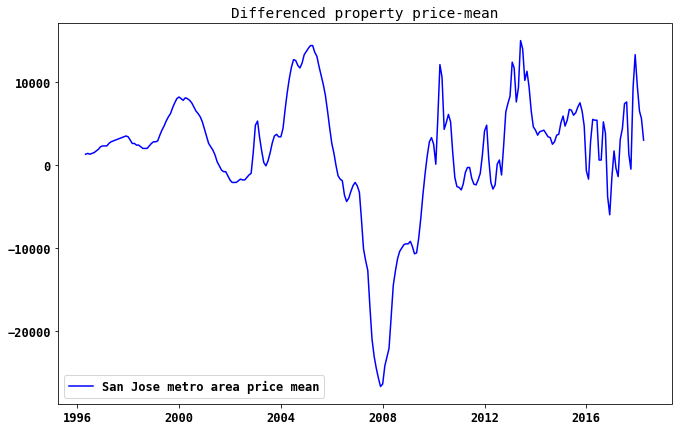

In [24]:
#We can also change the alignment of the dates on x-axis of time series plot by using :
#plt.gcf().autofmt_xdate()

city_df_diff = city_df.diff(periods=1)
#rcParams['figure.figsize'] = (11, 7)
#plt.plot(city_df_diff)

fig = plt.figure(figsize=(11,7))
plt.plot(city_df_diff, color='Blue',label='San Jose metro area price mean')
plt.legend(loc='best')
plt.title('Differenced property price-mean')
plt.show(block=False)

In [25]:
city_df_diff

,value
time,
1996-04-01,NaN
1996-05-01,1300.0
1996-06-01,1400.0
1996-07-01,1300.0
1996-08-01,1400.0
1996-09-01,1500.0
1996-10-01,1700.0
1996-11-01,1900.0
1996-12-01,2200.0


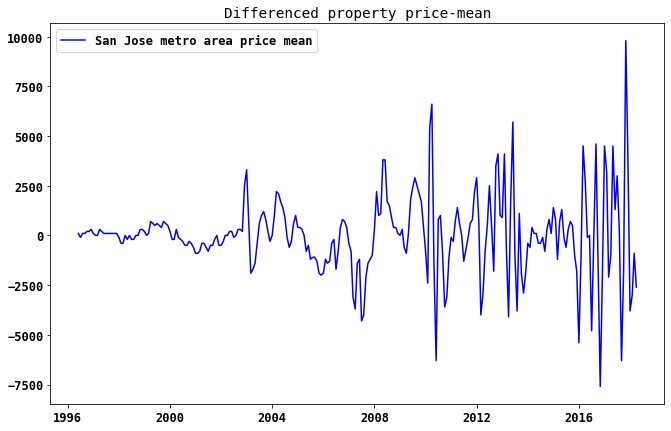

In [28]:
city_df_diff = city_df_diff.diff(periods=1)
fig = plt.figure(figsize=(11,7))
plt.plot(city_df_diff, color='Blue',label='San Jose metro area price mean')
plt.legend(loc='best')
plt.title('Differenced property price-mean')
plt.show(block=False)

In [31]:
city_df_diff.dropna(axis=0, inplace=True)

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(city_df_diff['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  -3.985234
p-value                          0.001490
#Lags Used                      14.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


the rolling mean and standard deviation is almost constant over the time,the Test Statistic is smaller than critical values and p-value is smaller than 0.05, **so the time series is stationary now and ready for modeling.**

In [34]:
city_df_diff

,value
time,
1996-06-01,100.0
1996-07-01,-100.0
1996-08-01,100.0
1996-09-01,100.0
1996-10-01,200.0
1996-11-01,200.0
1996-12-01,300.0
1997-01-01,100.0
1997-02-01,0.0


In [36]:
## split data: 70% train, 30% test 
train = city_df_diff.loc['2000-04-01':'2014-04-01']
test = city_df_diff.loc['2014-05-01':]

## ARIMA Model 

ARIMA (0, 2, 0):
                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  167
Model:                 ARIMA(0, 2, 0)   Log Likelihood               -1554.555
Method:                           css   S.D. of innovations           2669.847
Date:                Thu, 16 Apr 2020   AIC                           3113.111
Time:                        18:08:48   BIC                           3119.347
Sample:                    06-01-2000   HQIC                          3115.642
                         - 04-01-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5988    206.599      0.003      0.998    -404.328     405.525



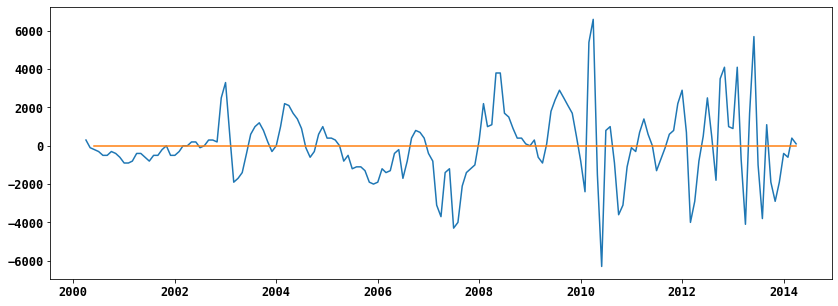


ARIMA (0, 2, 1):
                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  167
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -1498.634
Method:                       css-mle   S.D. of innovations           1881.037
Date:                Thu, 16 Apr 2020   AIC                           3003.269
Time:                        18:08:48   BIC                           3012.623
Sample:                    06-01-2000   HQIC                          3007.065
                         - 04-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0951      2.992      0.032      0.975      -5.770       5.960
ma.L1.D2.value    -1.0000      0.015    -67.404      0.000      -1.029      -0.971
                  

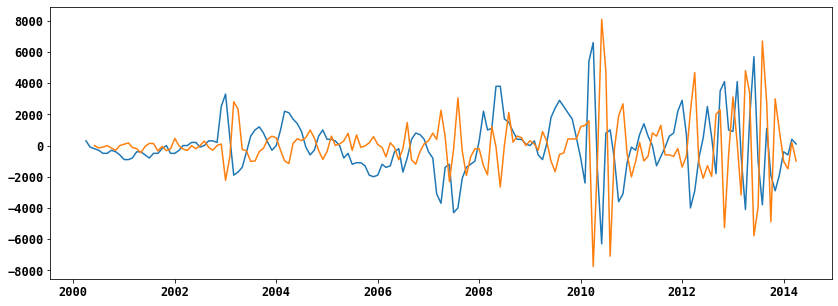


ARIMA (1, 2, 0):
                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  167
Model:                 ARIMA(1, 2, 0)   Log Likelihood               -1551.827
Method:                       css-mle   S.D. of innovations           2626.323
Date:                Thu, 16 Apr 2020   AIC                           3109.654
Time:                        18:08:48   BIC                           3119.008
Sample:                    06-01-2000   HQIC                          3113.450
                         - 04-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5988    172.549      0.003      0.997    -337.590     338.788
ar.L1.D2.value    -0.1789      0.076     -2.356      0.020      -0.328      -0.030
                  

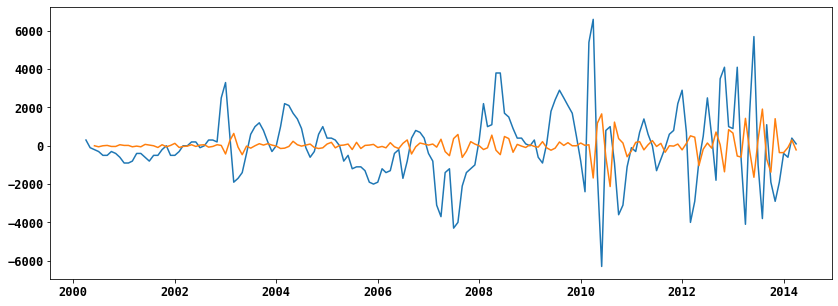


ARIMA (1, 2, 1):
                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  167
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1498.634
Method:                       css-mle   S.D. of innovations           1881.018
Date:                Thu, 16 Apr 2020   AIC                           3005.268
Time:                        18:08:48   BIC                           3017.740
Sample:                    06-01-2000   HQIC                          3010.330
                         - 04-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0948      2.988      0.032      0.975      -5.761       5.951
ar.L1.D2.value    -0.0015      0.077     -0.020      0.984      -0.153       0.150
ma.L1.D2.value    

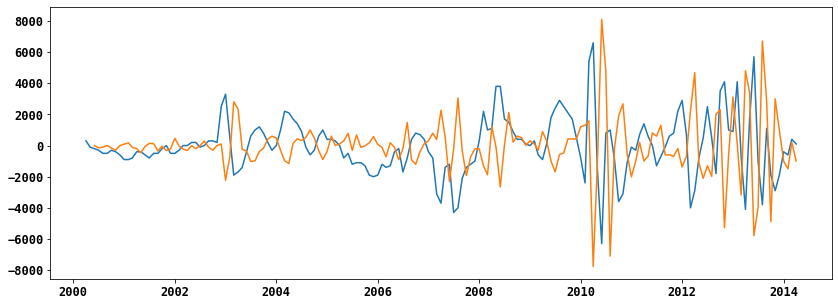


ARIMA (2, 2, 0):
                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  167
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -1493.674
Method:                       css-mle   S.D. of innovations           1846.459
Date:                Thu, 16 Apr 2020   AIC                           2995.348
Time:                        18:08:49   BIC                           3007.820
Sample:                    06-01-2000   HQIC                          3000.410
                         - 04-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.1148     71.484      0.016      0.988    -138.991     141.220
ar.L1.D2.value    -0.3054      0.054     -5.616      0.000      -0.412      -0.199
ar.L2.D2.value    

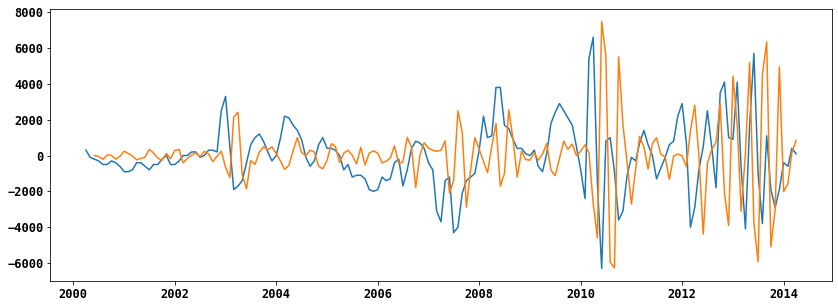


ARIMA (2, 2, 1):
                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                  167
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1453.289
Method:                       css-mle   S.D. of innovations           1424.907
Date:                Thu, 16 Apr 2020   AIC                           2916.579
Time:                        18:08:49   BIC                           2932.169
Sample:                    06-01-2000   HQIC                          2922.907
                         - 04-01-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0044      1.390     -0.003      0.997      -2.729       2.720
ar.L1.D2.value    -0.0099      0.059     -0.169      0.866      -0.125       0.105
ar.L2.D2.value    

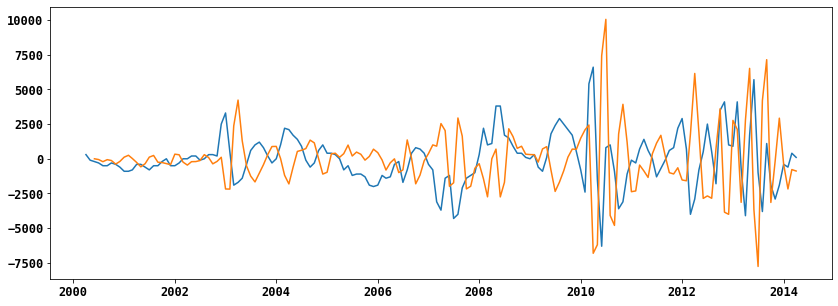

In [38]:
# Import ARMA
# we had two differencing process so our d=2
# p=q=range(0, 3)
from statsmodels.tsa.arima_model import ARIMA
comb = [(0, 2, 0),(0, 2, 1),(1, 2, 0),(1, 2, 1),(2, 2, 0),(2, 2, 1)]

for i in comb:
    # Fit an ARMA(1,0) model
    print('ARIMA {}:'.format(i))
    model = ARIMA(train, order= i)
    result = model.fit()
    plt.figure()
    # Print out summary information on the fit
    print(result.summary(),"\n")
    plt.plot(train)
    plt.plot(result.fittedvalues)
    plt.show()
    print()

### ARIMA (2, 2, 1) has the lowest AIC and residuals, so we are going to pick it as our final model to evaluate.